In [33]:
# !pip install --user uk-covid19==1.1.3

In [34]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib import cm, gridspec
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
import calendar
pd.set_option('display.max_rows', 365)
import warnings
warnings.filterwarnings('ignore')

In [35]:
start_date = '20210228' # Redownload from at least 7 days ago to update backdated cases by specimen date
end_date   = '20210304' # Latest date

In [36]:
from uk_covid19 import Cov19API
import requests
import json
import progressbar

measures = {"date": "date",
            "geo":"areaType",
            "area": "areaName",
            "code": "areaCode",
            "cases": "newCasesByPublishDate",
            "cases2": "newCasesBySpecimenDate", # in general, delayed by at least 5 days
            "admission": "newAdmissions",
            "hospital": "hospitalCases",
            "venti": "covidOccupiedMVBeds",
            "capacity":"plannedCapacityByPublishDate",
            "deaths": "newDeaths28DaysByPublishDate",
            "tests": "newTestsByPublishDate"}

pbar = progressbar.ProgressBar()
df = pd.DataFrame()
start = pd.to_datetime(start_date, format='%Y%m%d')
end   = pd.to_datetime(end_date,   format='%Y%m%d')

for d in pbar(range((end - start).days+1)):
# for d in range((end - start).days+1):
    for area in ['overview', 'nation', 'nhsregion', 'ltla']:
        date = start + pd.Timedelta(1, unit='days') * d
        date_str = f'{str(date)[:4]}-{str(date)[5:7]}-{str(date)[8:10]}'

        myfilters = [f"areaType={area}", f"date={date_str}"]

        api = Cov19API(filters=myfilters, structure=measures) #, latest_by="newCasesByPublishDate")
        data = api.get_json()

        df = pd.concat([df, pd.DataFrame(data['data'],columns=measures.keys())])
        
df.to_csv('uk_temp.csv')
df.head()

100% |########################################################################|


,date,geo,area,code,cases,cases2,admission,hospital,venti,capacity,deaths,tests
0,2021-02-28,overview,United Kingdom,K02000001,6035,4679,757,12773,1783,870136,144,527164
0,2021-02-28,nation,England,E92000001,5080,3918,662,10663,1630,None,115,489905
1,2021-02-28,nation,Northern Ireland,N92000002,136,131,6,327,30,None,3,2926
2,2021-02-28,nation,Scotland,S92000003,572,429,42,837,78,None,2,9982
3,2021-02-28,nation,Wales,W92000004,247,201,47,946,45,None,24,8600


In [37]:
prev_day = str(pd.to_datetime(start_date, format='%Y%m%d') + pd.DateOffset(-1))[:10].replace('-','')
file_old = f'uk{prev_day}.csv'
file_new = 'uk_temp.csv'
df1 = pd.read_csv(file_old, index_col=0)
df2 = pd.read_csv(file_new, index_col=0)
df  = pd.concat([df1, df2])
df.to_csv(f'uk{end_date}.csv')

In [38]:
df = pd.read_csv(f'uk{end_date}.csv', index_col=0)

df.date = pd.to_datetime(df.date)
df = df[df.area!='Resident outside Wales'].reset_index(drop=True)

geodata = pd.read_excel('utla.xlsx', usecols=['code','geotype','region','county','nhsRegion','region2','country','pop']).set_index('code')
df = df.join(geodata, on='code', how='left', rsuffix='2').fillna(0)

# # If using latest data
latest_date = df.date.max()

# # If using up till a point of time
# latest_date = pd.to_datetime('20200831', format='%Y%m%d')
# df = df[df.date <= latest_date]

In [39]:
# First and second wave
start_date1 = '20200306' # date of first death
start_tier  = '20200704' # date of introduction of Tier system
start_date2 = '20200801' # date of start of second wave
start_date3 = '20200831' # date of first jump in cases in second wave
start_date4 = '20210112' # date of decline from peak in January

In [40]:
def addcols(df, area):
    
    df['cases_avg7']    = round(df.groupby(area)['cases'].transform(lambda row: row.rolling(7, 1).mean()),1)
    df['cases2_avg7']   = round(df.groupby(area)['cases2'].transform(lambda row: row.rolling(7, 1).mean()),1)
    df['deaths_avg7']   = round(df.groupby(area)['deaths'].transform(lambda row: row.rolling(7, 1).mean()),1)
    df['admission_avg7']= round(df.groupby(area)['admission'].transform(lambda row: row.rolling(7, 1).mean()),1)
    df.hospital = df.hospital.replace({0:np.nan}).fillna(method='ffill')
    df['hospital_avg7'] = round(df.groupby(area)['hospital'].transform(lambda row: row.rolling(7, 1).mean()),1)
    
    df['cases_sum7']    = round(df.groupby(area)['cases'].transform(lambda row: row.rolling(7, 1).sum()),1)
    df['cases2_sum7']   = round(df.groupby(area)['cases2'].transform(lambda row: row.rolling(7, 1).sum()),1)
    df['deaths_sum7']   = round(df.groupby(area)['deaths'].transform(lambda row: row.rolling(7, 1).sum()),1)
    
    df['cases_100k']    = df.apply(lambda row: round(row['cases_sum7']/row['pop']*1e5,1) if row['pop']>0 else 0, axis=1)
    df['cases2_100k']   = df.apply(lambda row: round(row['cases2_sum7']/row['pop']*1e5,1) if row['pop']>0 else 0, axis=1)
    
    df['deaths_1M']     = df.apply(lambda row: round(row['deaths_sum7']/row['pop']*1e6,1) if row['pop']>0 else 0, axis=1)
    
    df['cases_sum7chg'] = df.groupby(area)['cases_sum7'].transform(lambda row: row - row.shift(7))
    df['cases2_sum7chg']= df.groupby(area)['cases2_sum7'].transform(lambda row: row - row.shift(7))
    
    df['cases_avg7chg'] = df.groupby(area)['cases_avg7'].transform(lambda row: row - row.shift(7))
    df['cases2_avg7chg']= df.groupby(area)['cases2_avg7'].transform(lambda row: row - row.shift(7))  
    df['hospital_avg7chg']= df.groupby(area)['hospital_avg7'].transform(lambda row: row - row.shift(7))
    
    df['wave'] = df.date.apply(lambda row: 1 if row < pd.to_datetime(start_date2, format='%Y%m%d') else 2)
    
    if area=='area':
        df = df.drop(['code','pop'], axis='columns').sort_values([area,'date'])
    else:
        df = df.drop(['pop'], axis='columns').sort_values([area,'date'])
    return df

In [41]:
# uk = df[df.geo=='nation']
# uk = uk.groupby(['date']).sum().reset_index()
# uk['area'] = 'United Kingdom'
# uk['code'] = 'K02000001'
# uk = addcols(uk, 'area')

# UK total
uk = df[df.geo=='overview']
uk = addcols(uk, 'area')

# England regions and devolved nations
nhsRegion = df[df.geo=='ltla'].groupby(['date','nhsRegion']).sum().reset_index()
nhsRegion = addcols(nhsRegion, 'nhsRegion')
nhsRegion = nhsRegion.rename({'nhsRegion':'area'}, axis=1)

# England total
england0 = df[(df.geo=='nation')&(df.area=='England')].reset_index(drop=True)
england0 = addcols(england0, 'area')

# Counties and sub-regions
regional = df[(df.geo=='ltla')&(df.county!='Northern Ireland')].groupby(['date','county']).sum().reset_index()
regional = addcols(regional, 'county')
regional = regional.rename({'county':'area'}, axis=1)

# Merge all
ukdata0 = pd.concat([uk, england0, nhsRegion, regional])

# Grouped regions (cases, deaths)
bigregion = df[df.geo=='ltla'].groupby(['date','region2']).sum().reset_index()
bigregion = addcols(bigregion, 'region2')
bigregion = bigregion.rename({'region2':'area'}, axis=1)
bigregion = pd.concat([uk, bigregion]).reset_index(drop=True)

# Grouped regions (admission, hospitalization)
nhsEngland = df[df.geo=='nhsRegion'].groupby(['date','region2']).sum().reset_index()
nhsNations = df[(df.geo=='nation')&(df.area!='England')].groupby(['date','region2']).sum().reset_index()
hospitalData = pd.concat([nhsEngland, nhsNations]).sort_values(['date','region2'])
hospitalData = addcols(hospitalData, 'region2')
hospitalData = hospitalData.rename({'region2':'area'}, axis=1)
hospitalData = pd.concat([hospitalData, uk]).sort_values(['date','region2']).reset_index(drop=True)

# England with Tier system data
geodata2 = geodata[['county','country','region2']].reset_index(drop=True).drop_duplicates().set_index('county')
tierdata = pd.read_excel('uk_tiers_history.xlsx').fillna('Tier system').set_index(['county','start'])[['tier','notes']]
england = regional[regional.date >= pd.to_datetime(start_tier, format='%Y%m%d')].join(geodata2, on='area', how='left')
england = england[england.country=='England'] # only keep England
england = england[england.region2!='London'].drop(['country','region2'], axis=1) # remove N/S/E/West London
england = pd.concat([england, bigregion[bigregion.area=='London']]) # use a combined London instead
england = england.join(tierdata, on=['area','date'], how='left')
england = england.sort_values(by=['area','date']).reset_index(drop=True)
england.tier = england.groupby(['area'], sort=False)['tier'].ffill()
england.notes = england.groupby(['area'], sort=False)['notes'].ffill().fillna('Pre-tier')

In [42]:
# Republic of Ireland data
url = 'https://opendata.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv'
ieraw = pd.read_csv(url)[['Date', 'ConfirmedCovidCases', 'ConfirmedCovidDeaths']]
ieraw.rename({'Date':'date','ConfirmedCovidCases':'cases0', 'ConfirmedCovidDeaths':'deaths0'}, axis=1, inplace=True)
ieraw.date = ieraw.date.apply(lambda row: pd.to_datetime(row[:10], format='%Y/%m/%d'))

ie = df[df.geo=='overview'].copy()
for col in ie.columns[1:]: ie[col] = np.nan
for col in ['geo','geotype']: ie[col] = 'ireland'
for col in ['area','county','region','nhsRegion','region2','country']: ie[col] = 'Republic of Ireland'
ie['pop'] = 4977400

ie = ie.join(ieraw.set_index('date'), on='date')
ie.drop(['cases','deaths'], axis=1, inplace=True)
ie.rename({'cases0':'cases', 'deaths0':'deaths'}, axis=1, inplace=True)
ie = ie.fillna(method='ffill')

ie = addcols(ie, 'area')

In [43]:
counties = list(regional[regional.date==max(regional.date)].sort_values('cases_avg7', ascending=False).area)
# counties.remove(0)
regions = list(nhsRegion[nhsRegion.date==max(nhsRegion.date)].sort_values('cases_avg7', ascending=False).area)
# regions.remove(0)
areas = ['United Kingdom'] + regions + ['Republic of Ireland'] + counties

# Data from day1 for UK total
ukdata_all = ukdata0[(ukdata0.area=='United Kingdom') & (ukdata0.date > pd.to_datetime(start_date1, format='%Y%m%d'))].reset_index(drop=True)

# Only analyze second wave data
ukdata = ukdata0[ukdata0.date > pd.to_datetime(start_date4, format='%Y%m%d')]
iedata = ie[ie.date > pd.to_datetime(start_date4, format='%Y%m%d')]

In [44]:
# Check if Region numbers are missing. Region is derived from LTLA, not Nation.
# nhsRegion[nhsRegion.area=='Scotland'].reset_index(drop=True).iloc[-10:][['date','cases','cases_avg7']]
# nhsRegion[nhsRegion.area=='Northern Ireland'].reset_index(drop=True).iloc[-10:][['date','cases','cases_avg7']]
# regional[regional.area=='Edinburgh/Lothian'].reset_index(drop=True).iloc[-10:][['date','cases','cases_avg7']]

# Scotland region missing (zero) since 25/12. NI missing (no records) since 24/12.
# Scotland and NI data during xmas comes from Nation, which is not missing (except NI, missing on 28/12).
# Scottish LTLA missing (zero) since 25/12. Wales is OK.

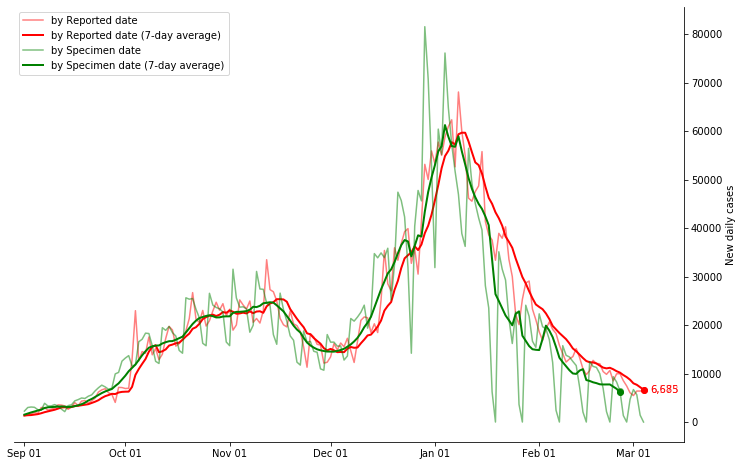

In [45]:
# Set number of past days to ignore due to incomplete data by specimen date
skip = 7

fig, ax = plt.subplots(figsize=(12,8))
data = ukdata0[(ukdata0.area=='United Kingdom')&(ukdata0.date>start_date3)]

ax.plot(data.set_index('date').cases, c='red', alpha=0.5, label='by Reported date')
ax.plot(data.set_index('date').cases_avg7, c='red', label='by Reported date (7-day average)', lw=2)
ax.plot(data.set_index('date').cases2, c='green', alpha=0.5, label='by Specimen date')
ax.plot(data.set_index('date').iloc[:-skip].cases2_avg7, c='green', label='by Specimen date (7-day average)', lw=2)

ax.scatter(data.iloc[-1].date, data.iloc[-1].cases, c='red', alpha=0.5)
ax.text(data.iloc[-1].date + pd.DateOffset(2), data.iloc[-1].cases, format(int(data.iloc[-1].cases),","), \
        c='red', ha='left', va='center', alpha=0.5)
ax.scatter(data.iloc[-1].date, data.iloc[-1].cases_avg7, c='red')
ax.text(data.iloc[-1].date + pd.DateOffset(2), data.iloc[-1].cases_avg7, format(int(data.iloc[-1].cases_avg7),","), \
        c='red', ha='left', va='center')
ax.scatter(data.iloc[-skip-1].date, data.iloc[-skip-1].cases2, c='green', alpha=0.5)
ax.scatter(data.iloc[-skip-1].date, data.iloc[-skip-1].cases2_avg7, c='green')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.set_xlim(data.date.min()+pd.DateOffset(-3), data.date.max()+pd.DateOffset(12))
ax.set_ylabel('New daily cases')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc='upper left')
plt.show()

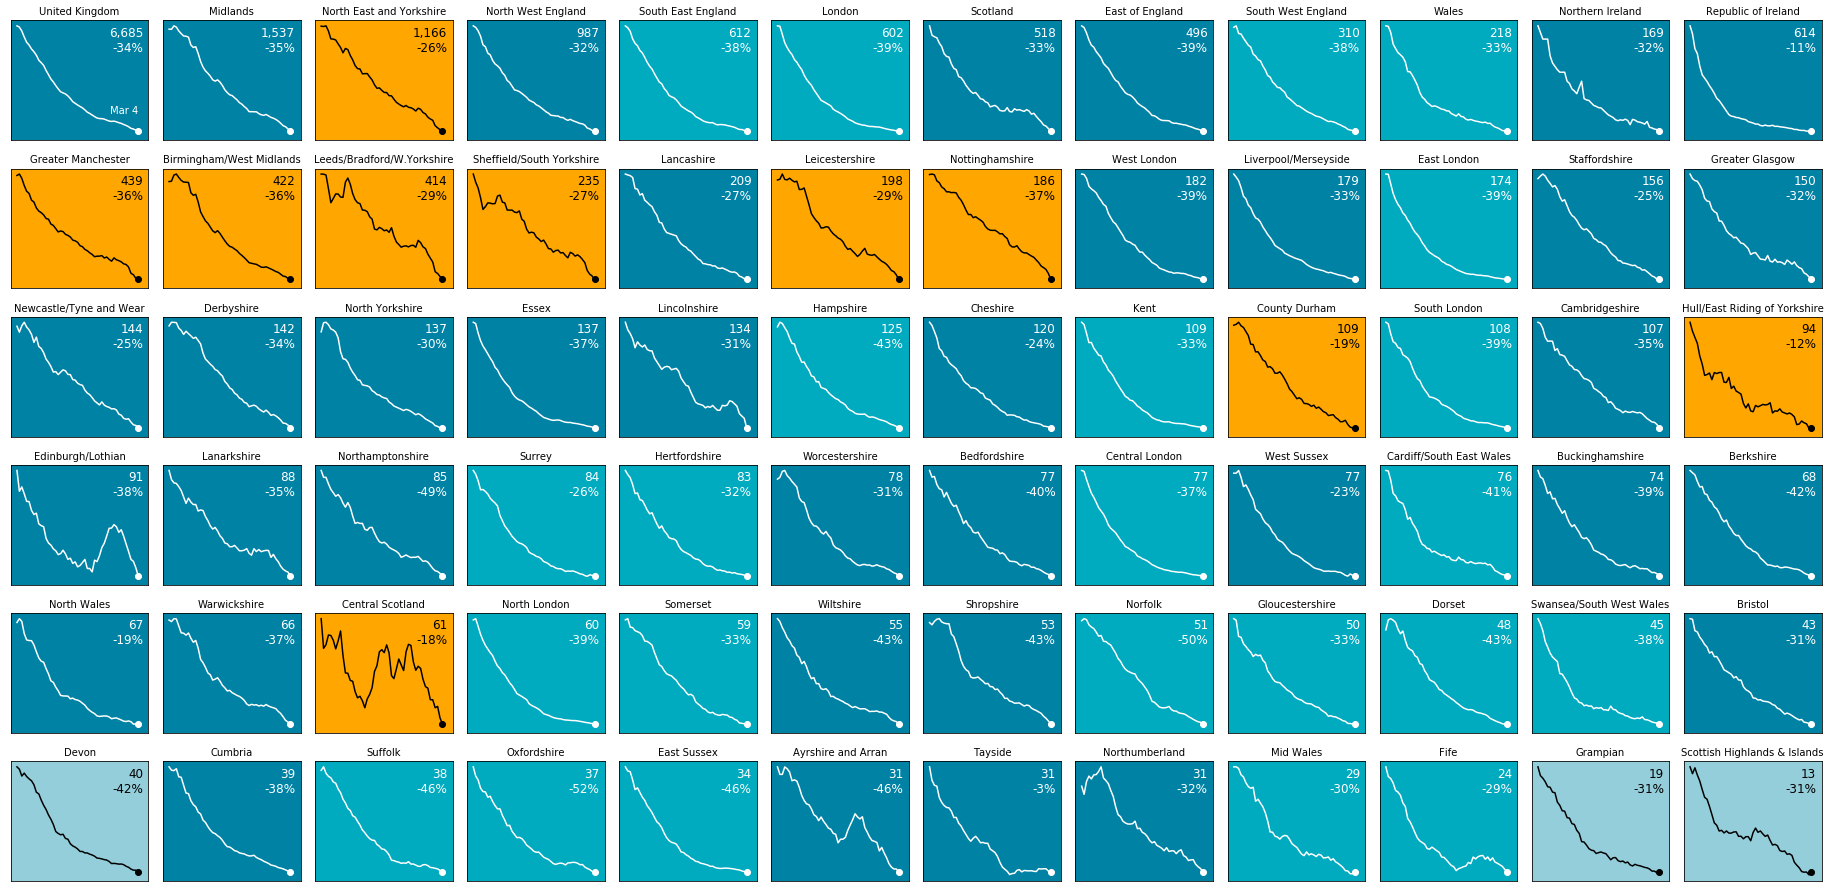

In [46]:
## Select 1 if showing as per reported date, or 2 if as per specimen date
show = 1

col1 = f"cases{2 if show==2 else ''}_100k"
col2 = f"cases{2 if show==2 else ''}_avg7"

one_day = pd.Timedelta(1, unit='days')
fig, axes = plt.subplots(figsize=(25.5,12.5), nrows=6, ncols=12)
source = pd.concat([ukdata, iedata])

for i, ax in zip(range(len(areas)), axes.flat):
    if show == 2:
        data = source[source.area==areas[i]].set_index('date').iloc[:-skip]
    else:
        data = source[source.area==areas[i]].set_index('date')
    
    first_date = data.index[0]
    latest_date2 = latest_date + pd.DateOffset(-skip if show==2 else 0)
    latest_val = data.iloc[-1][col2]
    max_value = max(data[col2])
    min_value = min(data[col2])
    
    prevalance = data.iloc[-1][col1]
    prevalence_past = data.loc[latest_date-one_day*7][col1] if show==1 else data.loc[latest_date2-one_day*7][col1]
    prevalence_chg = (prevalance - prevalence_past)/prevalence_past if prevalence_past>0 else 0
    
    bg_color = '#CBE2E6' if prevalance < 10 else ('#95CEDB' if prevalance < 25 else ('#00AABF' if prevalance < 50 else ('#0082A5' if prevalance < 100 else ('#FFA700' if prevalance < 200 else ('#E06900' if prevalance < 400 else ('#A80000' if prevalance < 600 else ('#640000' if prevalance < 1000 else 'black')))))))
    ln_color = 'black' if (prevalance<25)|((prevalance>=100)&(prevalance<400)) else 'white'
    
    ax.plot(data[col2], color=ln_color)
    ax.set_facecolor(bg_color)
    ax.scatter(latest_date2, latest_val, color=ln_color)
    
    prevalence_label = f'{"+" if prevalence_chg>=0.01 else ("-" if prevalence_chg<=-0.01 else "")}{int(abs(prevalence_chg*100))}%'
    ax.text(latest_date2 + pd.DateOffset(int(len(data)*0.05)), max_value,
            f'{format(int(latest_val), ",")}\n{prevalence_label}', size=12, color=ln_color, va='top', ha='right')
            
    ## When cases are increasing, use this:
    # ax.text(first_date, max_value, f'{format(int(latest_val), ",")}\n{prevalence_label}', size=12, color=ln_color, va='top', ha='left')
            
    if i==0: ax.text(latest_date2, min_value+(max_value-min_value)*0.15,
                     f'{calendar.month_name[latest_date2.month][:3]} {latest_date2.day}', color=ln_color, va='bottom', ha='right')
             
    ax.set_title(areas[i], fontsize=10) # if i>11 else ax.set_title(areas[i].upper(), fontsize=10)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
            
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=-1, hspace=-1)
plt.tight_layout()
plt.savefig(f"covid-uk1-prevalence_and_trend{'' if show==1 else '_by_specimen_dt'}", pad_inches=0)
plt.show()

<img src='scale_bbc.png' style="float:center">

In [47]:
# England lockdowns and measures
lockdowns = {'20201014':'3-Tier system in England',
             '20201106':'Second England lockdown',
             '20201202':'End of 2nd lockdown',
             '20201208':'Mass vaccination begins',
             '20201220':'Tier4 in London & Southeast',
             '20201231':'Tier4 in most of England',
             '20210106':'Third England lockdown'}

# Wales lockdowns and measures
lockdowns2 = {'20201023':'Wales firebreak lockdown',
              '20201109':'End of Wales firebreak lockdown',
              '20201226':'Northern Ireland lockdown'}

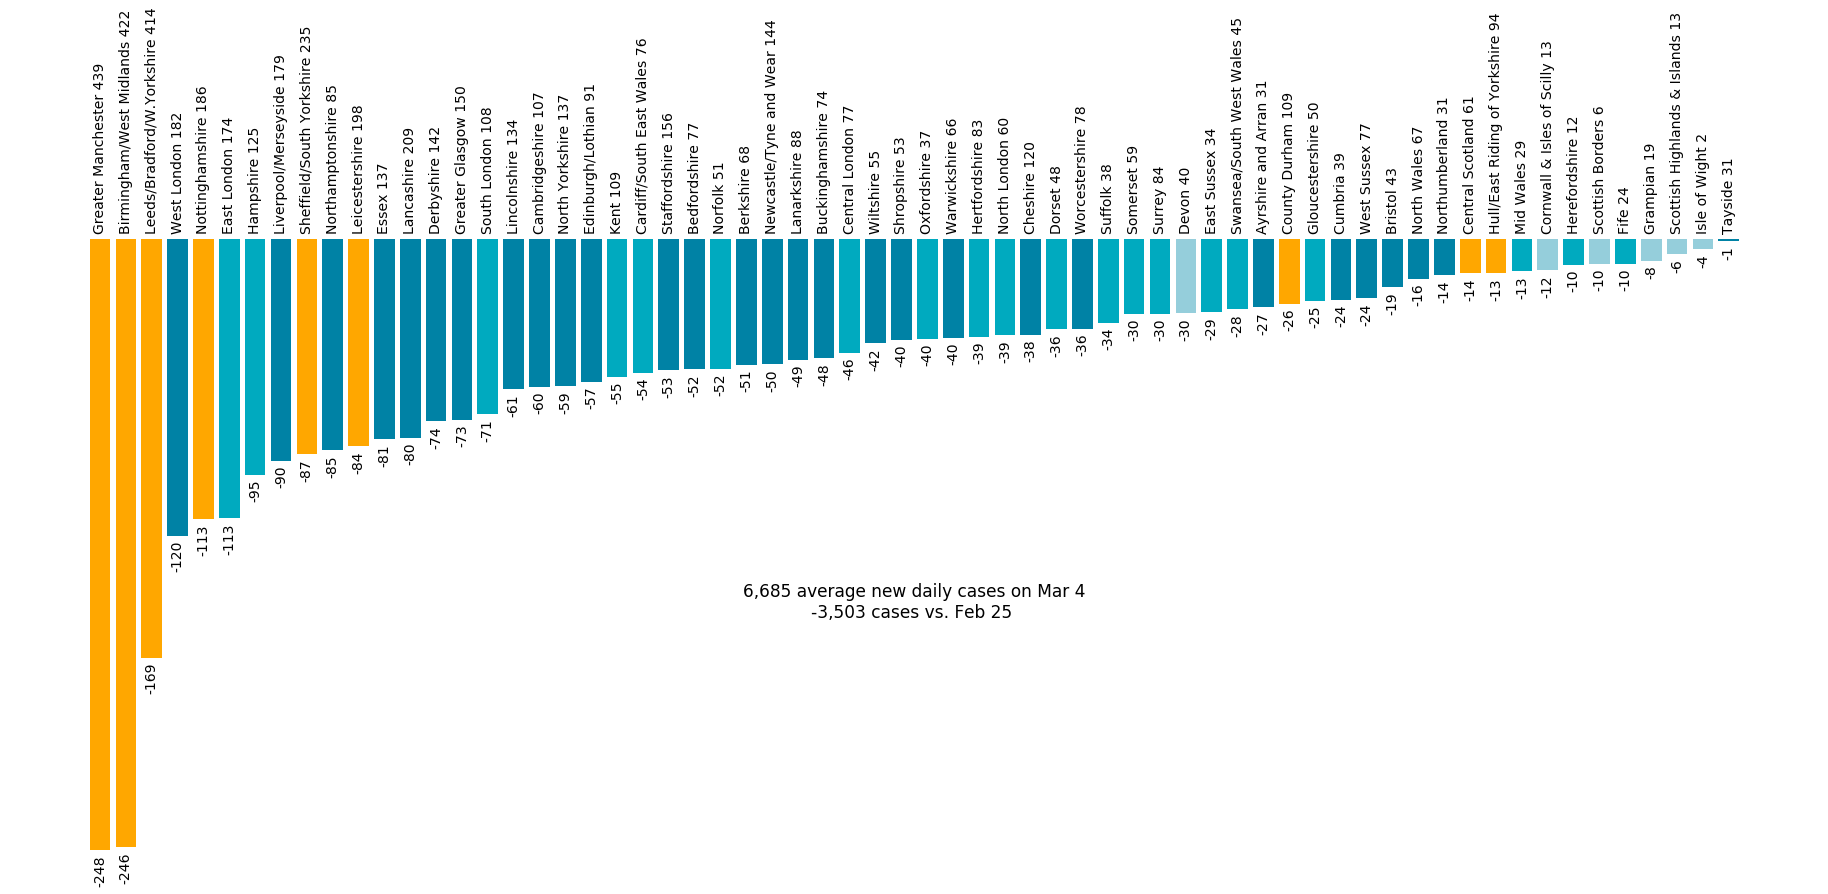

In [48]:
title_loc = 0.4 # reposition title as % of height

# dontshow = ['United Kingdom', 'England', 0]
showlist = counties
#showlist = counties + ['Northern Ireland', 'Scotland', 'Wales']

show_date = max(ukdata.date)
ukdata_chg = ukdata[(ukdata.date==show_date) & (ukdata.area.isin(showlist))].set_index('area').sort_values('cases_avg7chg', ascending=True)
arealist = list(ukdata_chg.index)

# low_chg = 10 # threshold for low numbers

# def color_bar(row):
#     if  (row.name in regions)&(row.cases_avg7chg>low_chg): return '#FFA700'
#     if ~(row.name in regions)&(row.cases_avg7chg>low_chg): return '#E06900'
#     if  (row.name in regions)&(row.cases_avg7chg<=low_chg)&(row.cases_avg7chg>= -(low_chg)): return 'navy'
#     if ~(row.name in regions)&(row.cases_avg7chg<=low_chg)&(row.cases_avg7chg>= -(low_chg)): return 'royalblue'
#     if  (row.name in regions)&(row.cases_avg7chg< -(low_chg)): return 'green'
#     else: return 'limegreen'

# ukdata_chg['color'] = ukdata_chg.cases_100k.apply(lambda row: '#CBE2E6' if row < 10 else ('#95CEDB' if row < 25 else ('#00AABF' if row < 50 else ('#0082A5' if row < 100 else ('#FFA700' if row < 200 else ('#E06900' if row < 400 else ('#A80000' if row < 600 else ('#640000' if row < 1000 else 'black'))))))))

ukdata_chg['color'] = ukdata_chg.cases_100k.apply(lambda row: '#CBE2E6' if row < 10 else ('#95CEDB' if row < 25 else ('#00AABF' if row < 50 else ('#0082A5' if row < 100 else ('#FFA700' if row < 200 else ('#E06900' if row < 400 else ('#A80000' if row < 600 else ('#640000' if row < 1000 else 'black'))))))))

fig, ax = plt.subplots(figsize=(25.5,12.5))
ax.bar(ukdata_chg.index, ukdata_chg.cases_avg7chg, color=list(ukdata_chg.color))
shift = 2
for i, area in enumerate(ukdata_chg.index):
    chg = ukdata_chg.iloc[i].cases_avg7chg
    avg = ukdata_chg.iloc[i].cases_avg7
    if chg < 0:
        x, va, va2, x2, label = shift, 'bottom', 'top', -shift, f'{area} {format(int(avg), ",")}'
    else:
        x, va, va2, x2, label = -shift, 'top', 'bottom', shift, f'{area} {format(int(avg), ",")}'
    ax.text(area, x, label, ha='center', va=va, fontsize=14, rotation=90)
    ax.text(area, chg+x2, f'{"+" if chg>0 else ""}{format(int(chg), ",")}', ha='center', va=va2, rotation=90, fontsize=14)
ax.axis('off')
max_date = max(ukdata.date).date()
past_date = max_date - one_day*7
uk_value = ukdata[(ukdata.date==max(ukdata.date)) & (ukdata.area=='United Kingdom')]
ax.set_title(f'{format(int(uk_value.cases_avg7), ",")} average new daily cases on {calendar.month_name[max_date.month][:3]} {max_date.day}\n{"+" if uk_value.cases_avg7chg.values[0] > 0 else ""}{format(int(uk_value.cases_avg7chg), ",")} cases vs. {calendar.month_name[past_date.month][:3]} {past_date.day} ', fontsize=17, y=title_loc)
plt.tight_layout()
plt.savefig('covid-uk2_changes_by_county', pad_inches=0)
plt.show()

In [49]:
region_order = ['United Kingdom', 'England',
                'London', 'East of England', 'South East England', 'South West England', 'Wales',
                'Midlands', 'North West England', 'North East and Yorkshire', 
                'Scotland', 'Northern Ireland', 'Republic of Ireland']
region_keys = {k:v for v, k in enumerate(region_order)}

region_list = geodata.groupby(['nhsRegion','county']).pop.sum().reset_index()
region_list['region_sort'] = region_list.nhsRegion.apply(lambda row: region_keys[row])
region_list = region_list.sort_values(['region_sort','pop'], ascending=[True,False]).reset_index()
region_list = region_list.county
region_list = list(region_list) + ['Republic of Ireland']

data = pd.concat([ukdata0, ie])
data = data[data.date>=pd.to_datetime(start_date2, format='%Y%m%d')]
data['date'] = data['date'].dt.date
dfgrid = pd.pivot_table(data, values='cases_100k', index='date', columns='area', aggfunc=np.sum)
dfgrid = dfgrid[region_list]

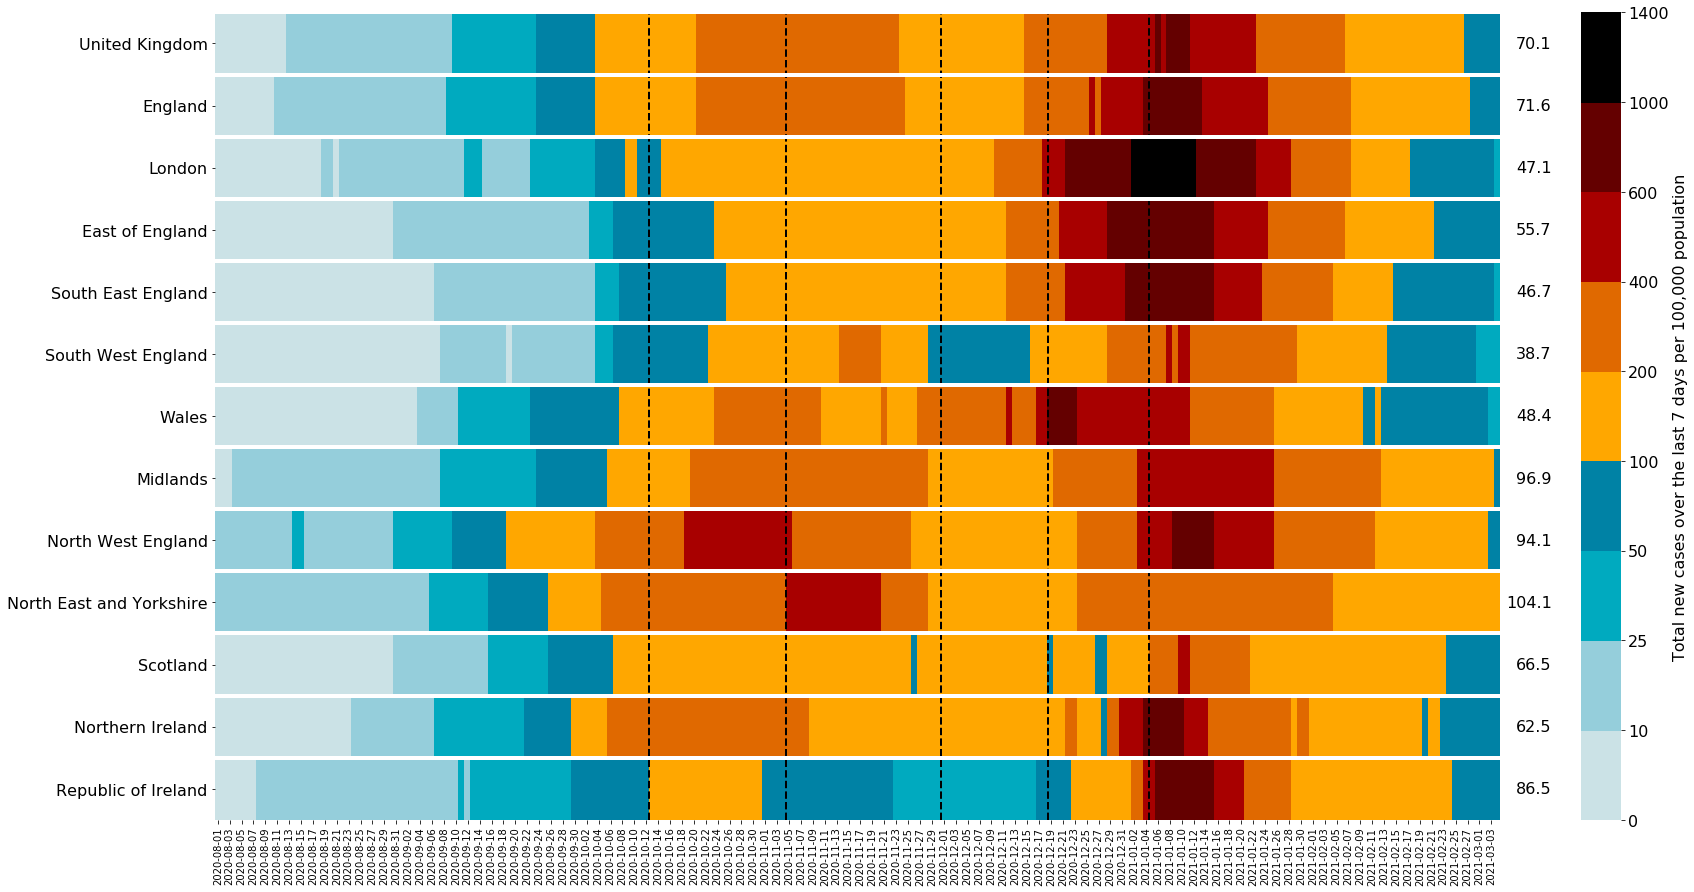

In [50]:
fig, ax = plt.subplots(figsize=(25.5,12.5))

cmap = colors.ListedColormap(['#CBE2E6','#95CEDB','#00AABF','#0082A5','#FFA700','#E06900','#A80000','#640000','black'])
bounds=[0,10,25,50,100,200,400,600,1000,1400]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax = sns.heatmap(dfgrid[region_order].T, cmap=cmap, norm=norm)
    
for n, latest in enumerate(dfgrid[region_order].iloc[-1].T):
    ax.text(len(dfgrid[region_order].index)*1.04, n+0.5, round(latest,1), ha='right', va='center', size=16)

ax.vlines([73,96,122,140,157], *ax.get_ylim(), ls='dashed', lw=2)
ax.hlines(range(len(region_order)), *ax.get_xlim(), color='white', lw=4)  

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(bounds)
colorbar.set_ticklabels(bounds)
colorbar.set_label('Total new cases over the last 7 days per 100,000 population', size=16)
colorbar.ax.tick_params(labelsize=16) 

ax.tick_params(axis='y', labelsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_xlabel('')

# txt = 'Compiled by Khairul Omar | @khairultweets | github.com/khairulomar'
# plt.figtext(0.16,0.01, txt, fontsize=10, ha='left', va='top')

plt.tight_layout()
plt.savefig(f"covid-uk3_incidence_rate_by_region", pad_inches=0, bbox_inches="tight")
plt.show()

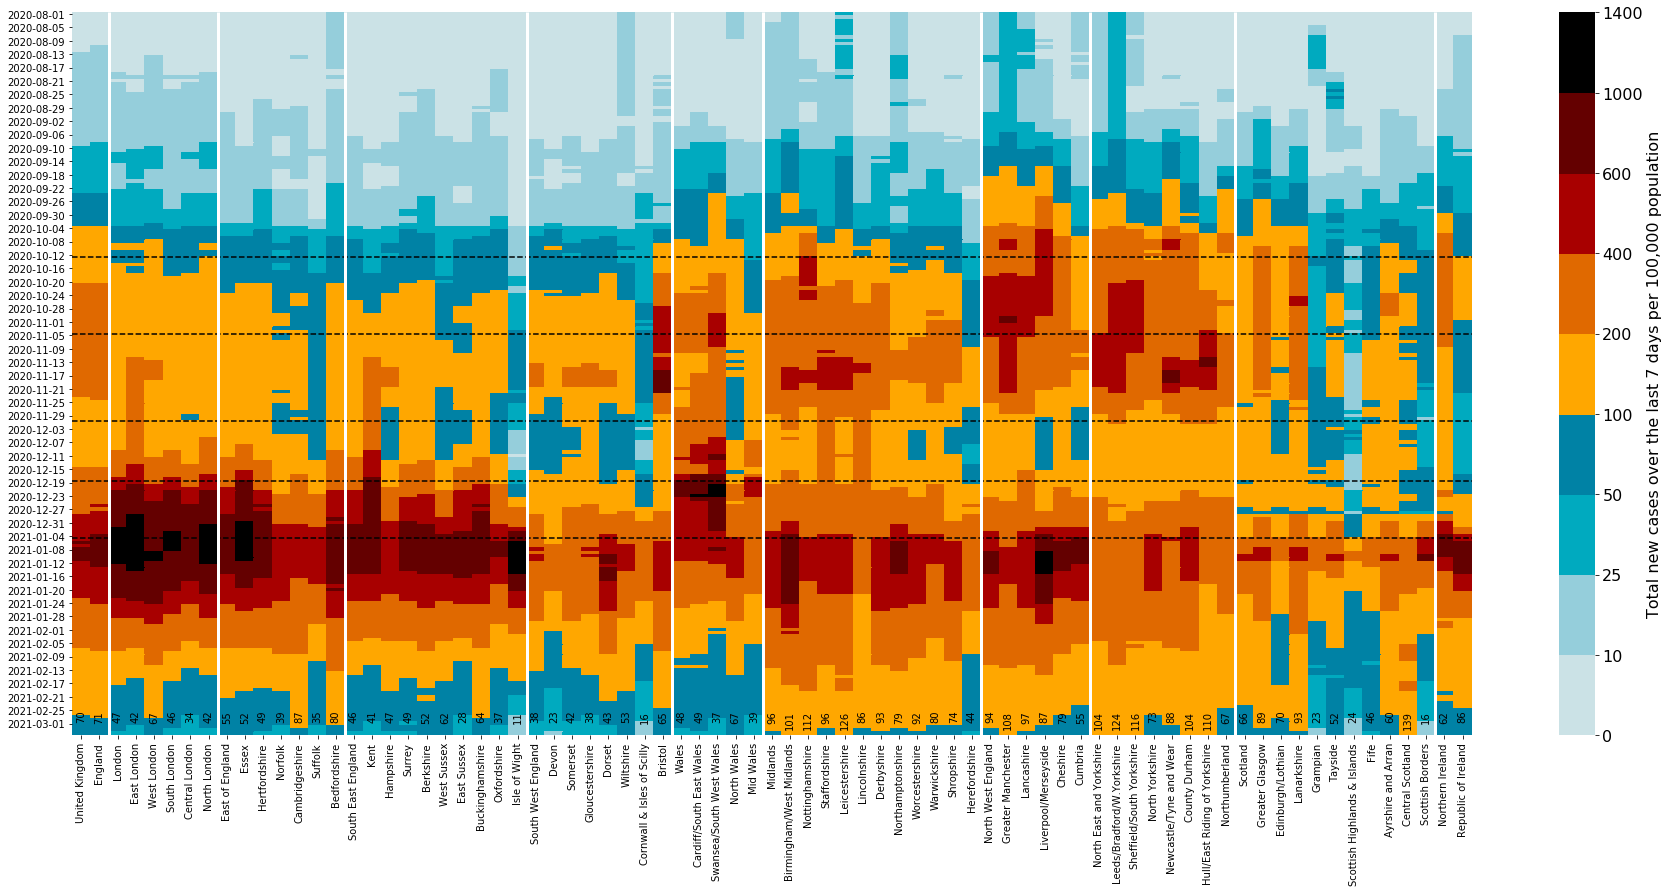

In [51]:
fig, ax = plt.subplots(figsize=(25.5,12.5))

cmap = colors.ListedColormap(['#CBE2E6','#95CEDB','#00AABF','#0082A5','#FFA700','#E06900','#A80000','#640000','black'])
bounds=[0,10,25,50,100,200,400,600,1000,1400]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax = sns.heatmap(dfgrid, cmap=cmap, norm=norm)

ax.hlines([73,96,122,140,157], *ax.get_xlim(), ls='dashed')
region_list2 = pd.DataFrame(region_list[:-1])
ax.vlines(region_list2[region_list2.isin(region_order)].dropna().index[2:], *ax.get_ylim(), color='white', lw=3)    
    
for n, latest in enumerate(dfgrid.iloc[-1].T):
    ax.text(n+0.5,len(dfgrid.index)*0.965, int(latest), ha='center', va='top', rotation=90)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(bounds)
colorbar.set_ticklabels(bounds)
colorbar.set_label('Total new cases over the last 7 days per 100,000 population', size=16)
colorbar.ax.tick_params(labelsize=16) 

plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_ylabel('')    
ax.set_xlabel('')

plt.tight_layout()
plt.savefig(f"covid-uk4_incidence_rate_by_county", pad_inches=0, bbox_inches="tight")
plt.show()

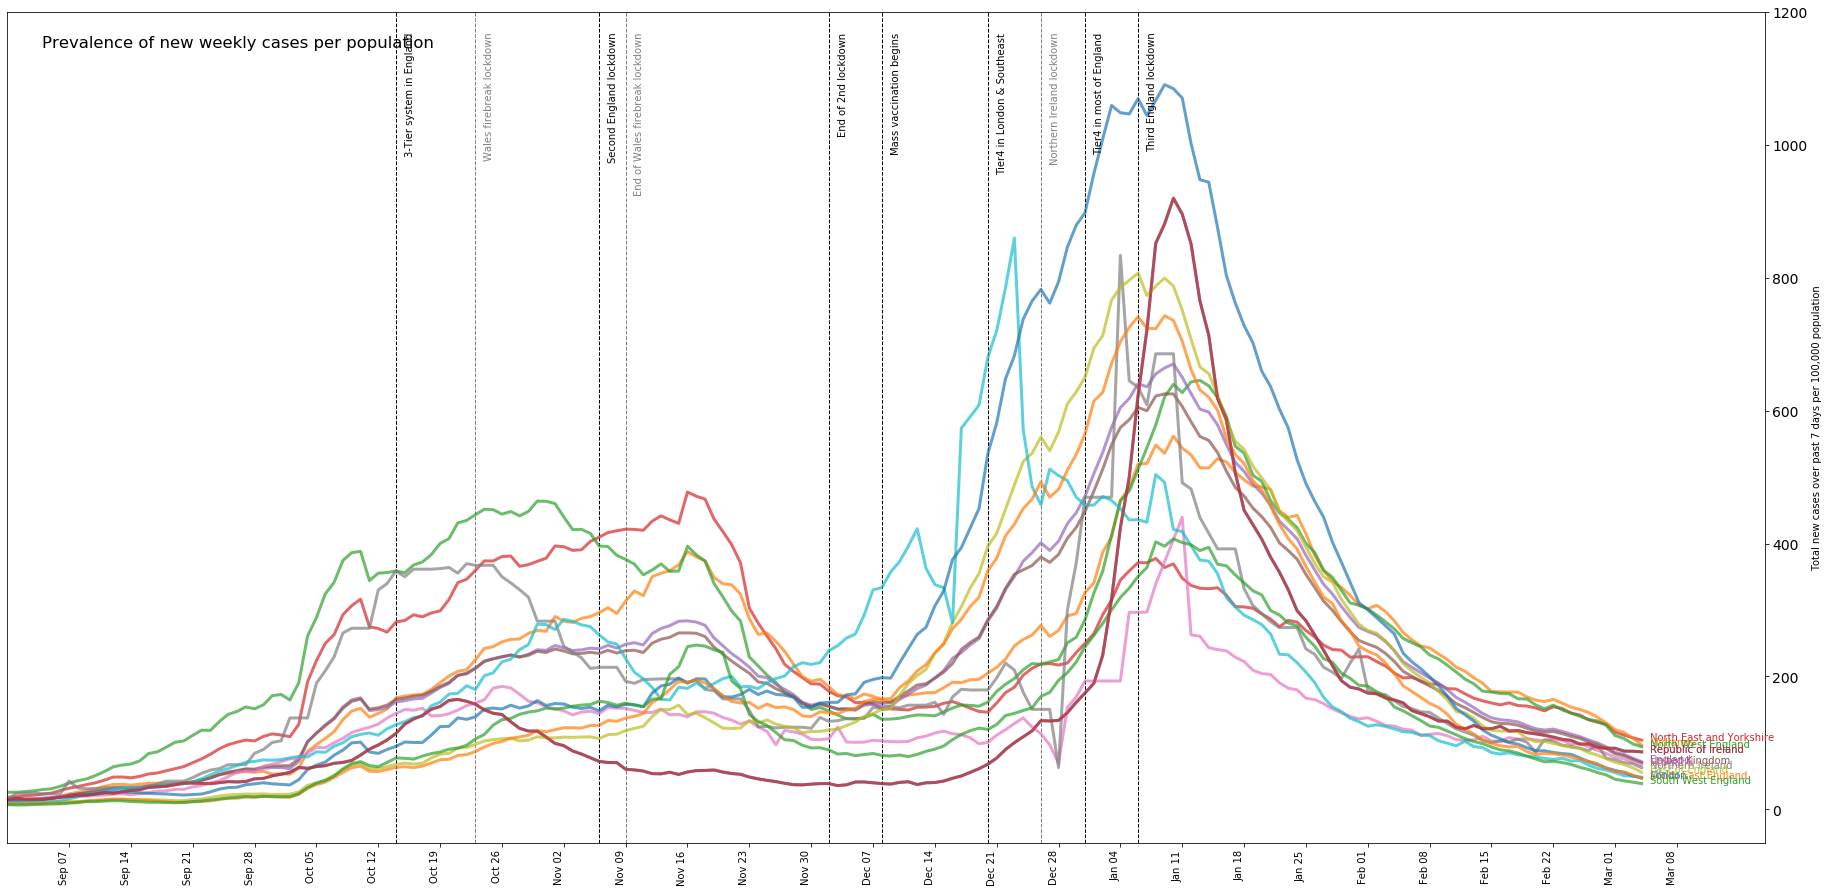

In [52]:
# Select 1 if showing as per reported date, or 2 if as per specimen date
show = 1

source0 = pd.concat([nhsRegion, england0, uk, ie])
source  = source0[source0.date < (latest_date + pd.DateOffset(-skip+1))] if show == 2 else source0
col1 = f"cases{2 if show==2 else ''}_100k"

# Adjust max if needed
ymax = 1200

# Xticks day labels
day = pd.to_datetime(start_date3, format='%Y%m%d')
xticks = []
while day <= source.date.max():
    day = day + pd.DateOffset(7)
    xticks.append(day)

latest_date2 = source.date.max()
regions2 = list(source[source.date == latest_date2].sort_values(col1, ascending=False).area) + ['Republic of Ireland']
# regions2.remove(0)

fig, ax = plt.subplots(figsize=(25.5,12.5))

for n in range(len(lockdowns)):
    ax.vlines(pd.to_datetime(list(lockdowns.keys())[n], format='%Y%m%d'), -50, ymax+50, lw=1, dashes='--')
    ax.text(pd.to_datetime(list(lockdowns.keys())[n], format='%Y%m%d') + pd.DateOffset(1), ymax-30, list(lockdowns.values())[n], rotation=90, va='top')

for n in range(len(lockdowns2)):
    ax.vlines(pd.to_datetime(list(lockdowns2.keys())[n], format='%Y%m%d'), -50, ymax+50, lw=1, dashes='--', color='grey')
    ax.text(pd.to_datetime(list(lockdowns2.keys())[n], format='%Y%m%d') + pd.DateOffset(1), ymax-30, list(lockdowns2.values())[n], rotation=90, va='top', color='grey')

for n, region in enumerate(regions2):
    data = source[(source.area==region) & (source.date > pd.to_datetime(start_date2, format='%Y%m%d'))].set_index('date')[col1]
    color = 3 if n==0 else (0 if n==3 else n)
    ax.plot(data, label=region, c=f'C{color}', lw=3, alpha=0.7)
    ax.text(latest_date2 + pd.DateOffset(1), data.loc[latest_date2], region, c=f'C{color}', fontsize=10)
    
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

ax.set_xlim(pd.to_datetime(start_date3, format='%Y%m%d'), latest_date + pd.DateOffset(14))
ax.set_xticks(xticks)
ax.set_ylim(-50, ymax)

plt.ylabel('Total new cases over past 7 days per 100,000 population')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.tick_params(axis="y", labelsize=14)
ax.set_title('Prevalence of new weekly cases per population', fontsize=16.5, x=0.02, y=0.95, horizontalalignment='left')

fig.autofmt_xdate(rotation=90)
plt.tight_layout()
plt.savefig(f"covid-uk5_incidence_rate_by_region{'' if show==1 else '_by_specimen_dt'}", pad_inches=0)
plt.show()

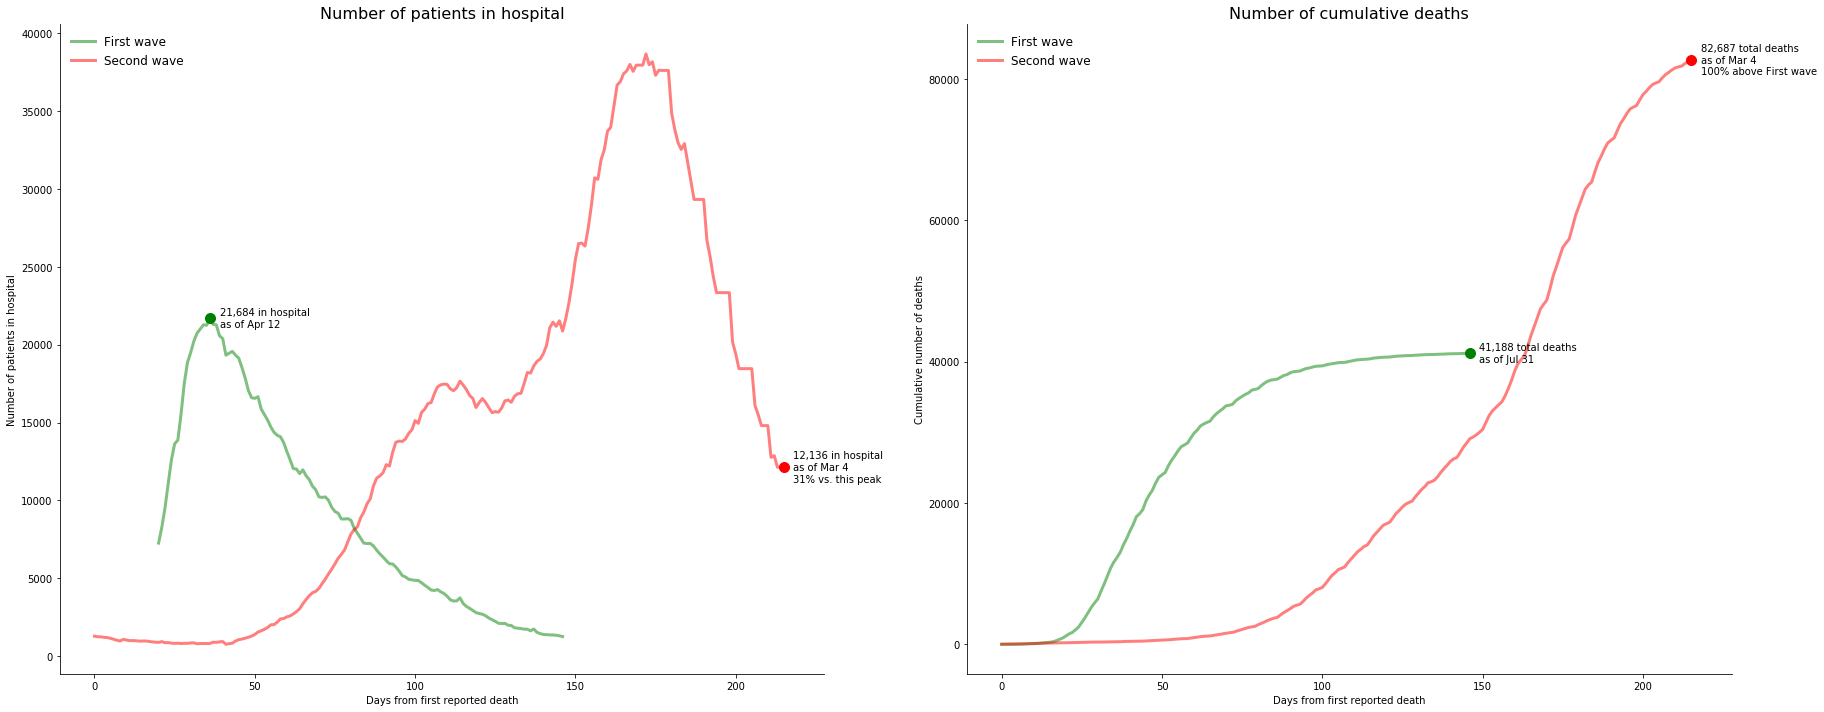

In [53]:
cols    = ['hospital', 'deaths_total']
ylabels = ['Number of patients in hospital', 'Cumulative number of deaths']
titles  = ['Number of patients in hospital', 'Number of cumulative deaths']
# no_hospital_period = ukdata_all[(ukdata_all.hospital==0)&(ukdata_all.wave>1)].date.max()

fig, axes = plt.subplots(figsize=(25.5,10), nrows=1, ncols=2)
for i, ax in zip(range(2), axes.flat):
    
    col = cols[i]
    
    # Select source
    ukwaves = ukdata_all.copy()
    # ukwaves = hospitalData[hospitalData.area=='London']
    
    ukwaves['deaths_total'] = ukwaves.groupby('wave').deaths.cumsum()
    ukwave1 = ukwaves[ukwaves.wave==1]
    ukwave2 = ukwaves[ukwaves.wave==2].reset_index(drop=True)

    end1_day     = ukwave1.index.max()
    end1_date    = ukwave1.date.max().date()
    end1_value   = ukwave1[ukwave1.date==ukwave1.date.max()][col]
    max_value1   = ukwave1[col].max()
    max_day1     = ukwave1[ukwave1[col]==max_value1].index[0]
    max_date1    = ukwave1[ukwave1[col]==max_value1].date.max()
    
    start2_day   = ukwave2.index.min()
    start2_date  = ukwave2.date.min().date()
    start2_value = ukwave2[ukwave2.date==ukwave2.date.min()][col]
    max_value2   = ukwave2[col].max()
    max_day2     = ukwave2[ukwave2[col]==max_value2].index[0]
    max_date2    = ukwave1[ukwave2[col]==max_value2].date.max()
    
    latest_day   = ukwave2.index.max()
    latest_date  = ukwave2.date.max().date()
    latest_value = ukwave2[ukwave2.date==ukwave2.date.max()][col]

    ax.plot(ukwave1.reset_index()[col], c='green', lw=3, alpha=0.5, label='First wave')
    ax.plot(ukwave2.reset_index()[col], c='red', lw=3, alpha=0.5, label='Second wave')

    if i==0:
        ax.scatter(max_day1, max_value1, c='green', s=100)
        ax.scatter(latest_day, latest_value, c='red', s=100)
        ax.text(max_day1+3, max_value1, f'{format(int(max_value1),",")} in hospital\nas of {calendar.month_name[max_date1.month][:3]} {max_date1.day}', \
                va='center', ha='left')
        ax.text(latest_day+3, latest_value, f'{format(int(list(latest_value)[0]),",")} in hospital\nas of {calendar.month_name[latest_date.month][:3]} {latest_date.day}\
                \n{int(list(latest_value)[0]/max_value2*100)}% vs. this peak', \
                va='center', ha='left')   
    else:
        ax.scatter(end1_day, end1_value, c='green', s=100)
        ax.scatter(latest_day, latest_value, c='red', s=100)
        ax.text(end1_day+3, end1_value, f'{format(int(list(end1_value)[0]),",")} total deaths\nas of {calendar.month_name[end1_date.month][:3]} {end1_date.day}', \
                va='center', ha='left')
        ax.text(latest_day+3, latest_value, f'{format(int(list(latest_value)[0]),",")} total deaths\nas of {calendar.month_name[latest_date.month][:3]} {latest_date.day}\
                \n{int(list(latest_value)[0]/list(end1_value)[0]*100)-100}% above First wave', \
                va='center', ha='left')    
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(titles[i], fontsize=16)
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('Days from first reported death')
    ax.legend(loc='upper left', frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig('covid-uk6_wave1_vs_wave2', pad_inches=0)
plt.show()

In [54]:
# print('Top 20 County or Region with the highest prevalence rate')
# prev_latest = ukdata[ukdata.date==ukdata.date.max()][['area','cases_100k']].sort_values('cases_100k', ascending=False).reset_index(drop=True)
# prev_specim = ukdata[ukdata.date==(ukdata.date.max()+ pd.DateOffset(-skip))][['area','cases2_100k']].reset_index(drop=True)
# top_prev = prev_latest.join(prev_specim.set_index('area'), on='area').rename(columns={"cases_100k": "By reported date (latest)", "cases2_100k":f"By specimen date ({skip} days ago)", "area":"County or Region"})
# display(top_prev.iloc[:20].set_index('County or Region', drop=True))

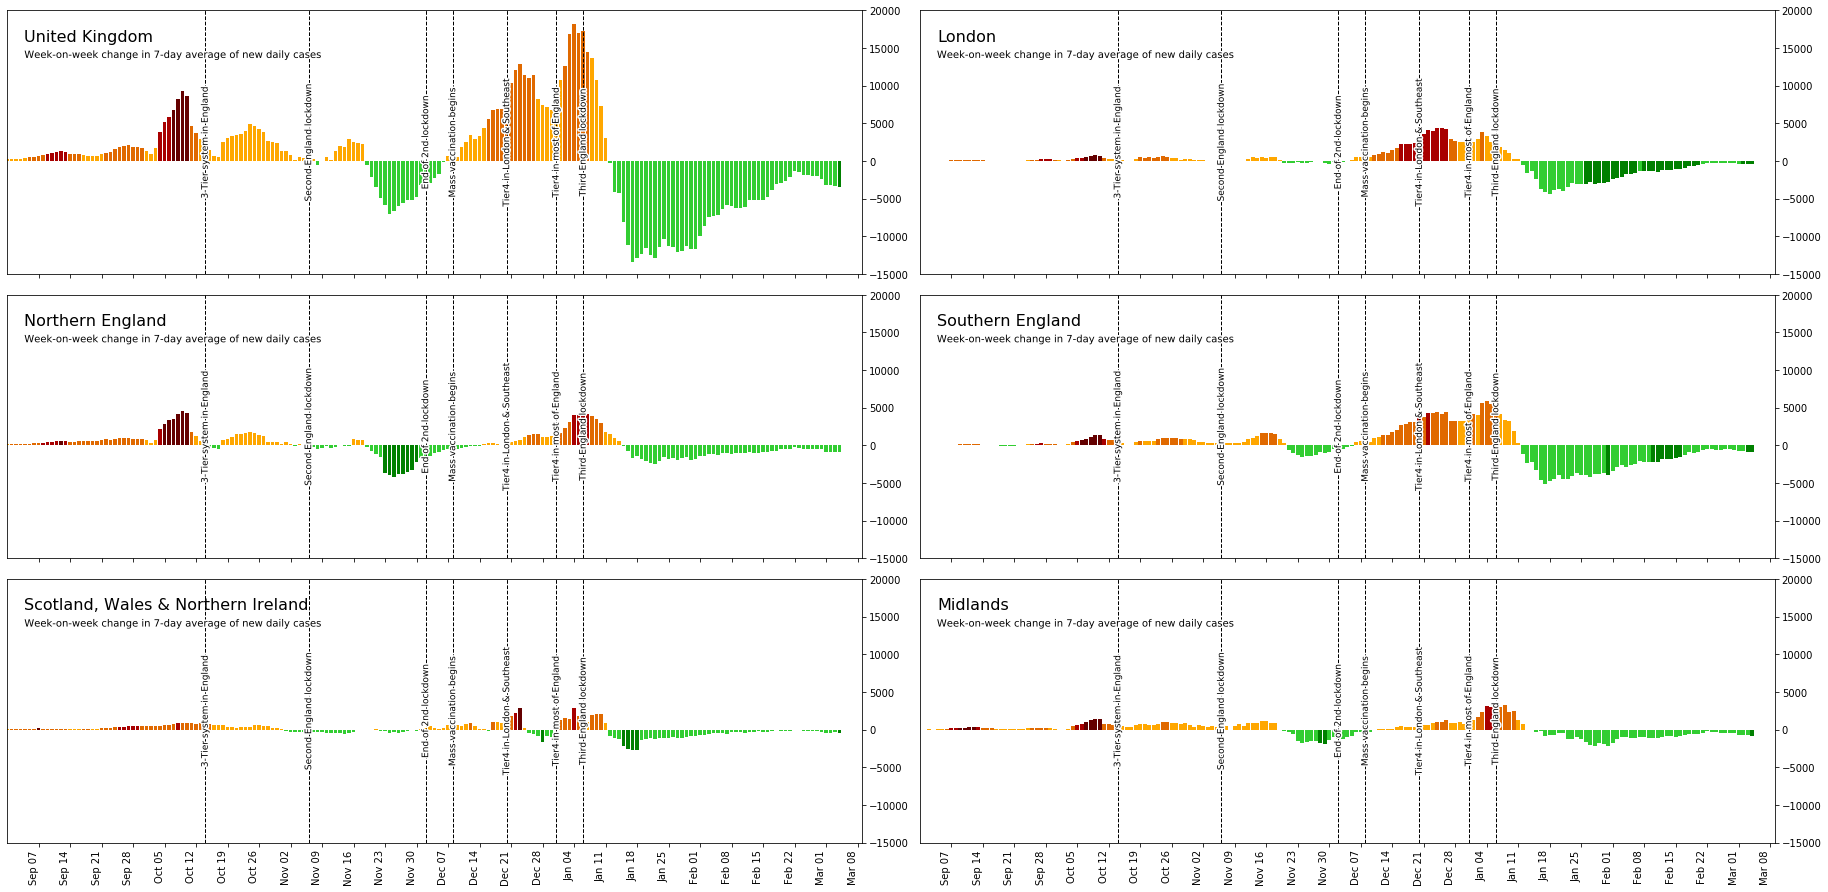

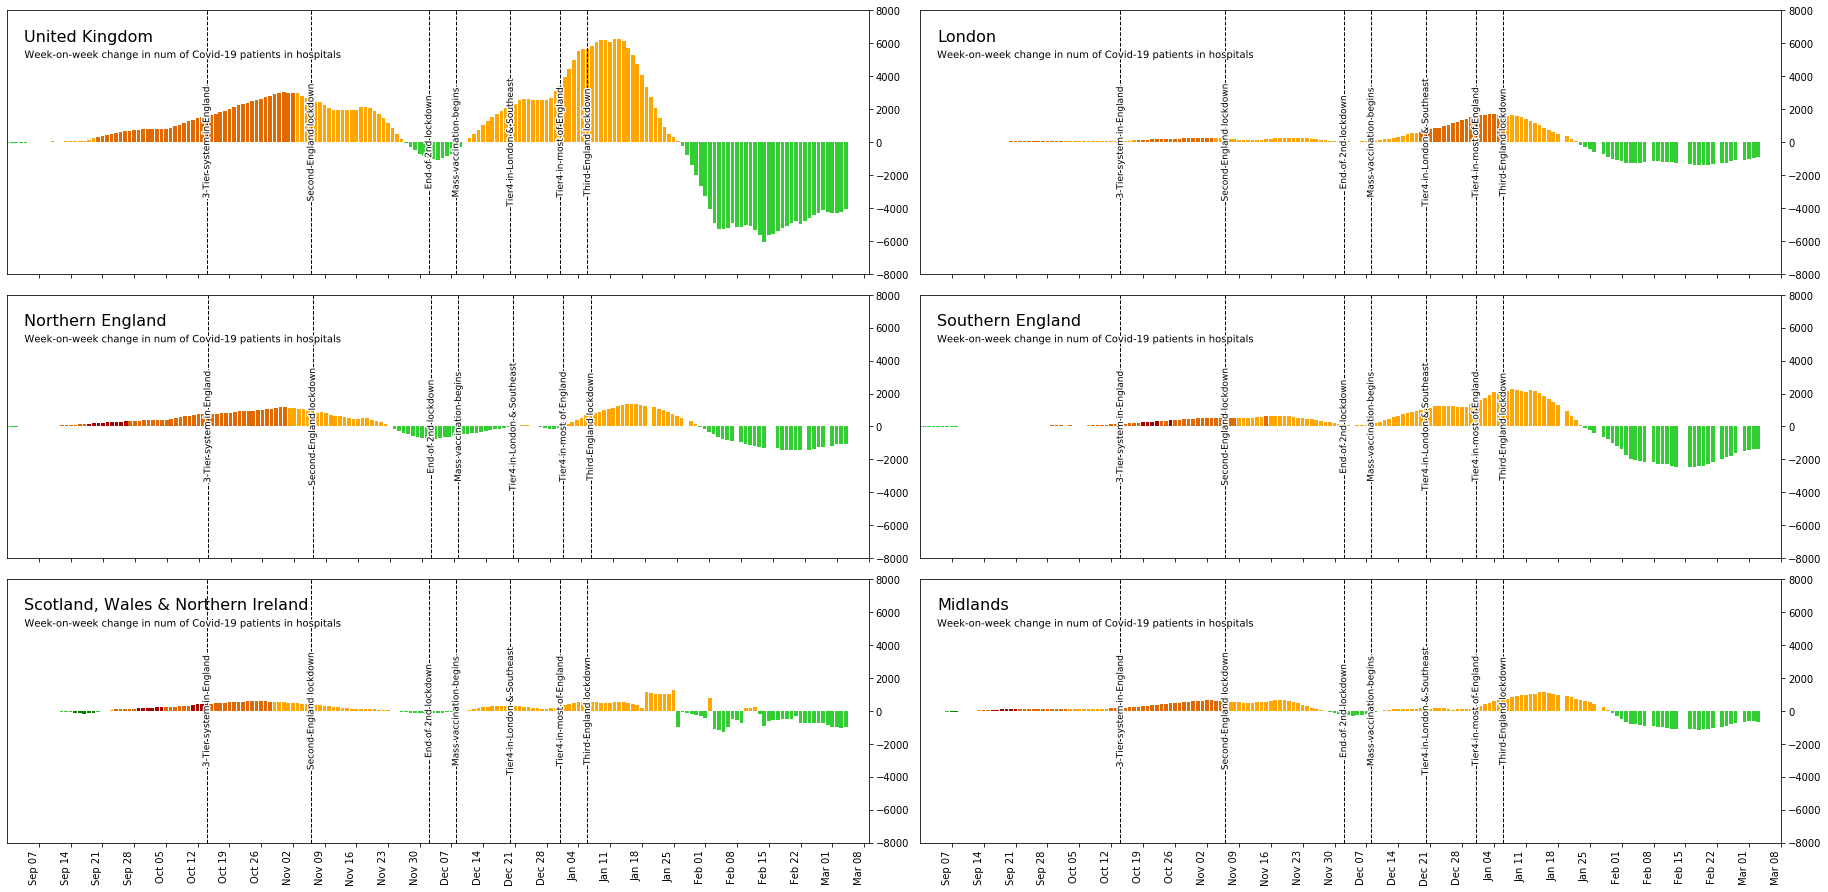

In [55]:
# Adjust max if needed
ylim = [[-15000, 20000], # for cases
        [-8000, 8000]]   # for hospital data

date_min = pd.to_datetime(start_date3, format='%Y%m%d')

# Select 1 if showing as per reported date, or 2 if as per specimen date
show = 1

measure = ['cases', 'hospital']

bigregion_list = ['United Kingdom',
                  'London',
                  'Northern England',
                  'Southern England',
                  'Scotland, Wales & Northern Ireland',                  
                  'Midlands']

titles = ['Week-on-week change in 7-day average of new daily cases',
          'Week-on-week change in num of Covid-19 patients in hospitals']

for m in range(len(measure)):
    
    fig, axes = plt.subplots(figsize=(25.5,12.5), nrows=3, ncols=2)
    for i, ax in zip(range(len(bigregion_list)), axes.flat):

        if m==0: source = bigregion
        else: source = hospitalData

        if (show==2)&(m==0): source = source[source.date < latest_date + pd.DateOffset(-skip+1)]

        ref = 2 if (show==2)&(m==0) else ''
        col1 = f"{measure[m]}{ref}_avg7"
        col2 = f"{measure[m]}{ref}_avg7chg"    

        data = source[source.area==bigregion_list[i]]
        data = data[data.date > pd.to_datetime(start_date2, format='%Y%m%d') \
                               +pd.DateOffset(-14)][['date', col1, col2]]
        data['cases_avg7chg_pct'] = data[col1].transform(lambda row: (row-row.shift(7))/row.shift(7)*100)
        data = data.reset_index(drop=True).iloc[7:].reset_index(drop=True)
        data['color'] = data.cases_avg7chg_pct.apply(lambda row: 'green' if row < -33 else \
                        ('limegreen' if row < 0 else ('#FFA700' if row < 33 else \
                        ('#E06900' if row < 66 else ('#A80000' if row < 100 else '#640000')))))
        data = data.set_index('date', drop=True)

        # Xticks day labels
        day = pd.to_datetime(start_date3, format='%Y%m%d')
        xticks = []
        while day <= data.index.max():
            day = day + pd.DateOffset(7)
            xticks.append(day)

        ax.bar(data.index, data[col2], color=list(data.color))

        for n in range(len(lockdowns)):
            ax.vlines(pd.to_datetime(list(lockdowns.keys())[n], format='%Y%m%d'), ylim[m][0], ylim[m][1], lw=1, dashes='--')
            ax.text(pd.to_datetime(list(lockdowns.keys())[n], format='%Y%m%d') + pd.DateOffset(0), (ylim[m][0]+ylim[m][1])/2, list(lockdowns.values())[n], rotation=90, va='center', ha='center', size=9, \
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')])

        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
        ax.set_xticks(xticks)
        ax.set_xlim(date_min, data.index.max() + pd.DateOffset(5))

        ax.set_ylim(ylim[m][0], ylim[m][1])
        # ax.set_ylabel('Weekly change of avg new daily cases')
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')

        # ax.text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
        ax.text(0.02, 0.93, bigregion_list[i], va='top', ha='left', size=16, transform=ax.transAxes)
        ax.text(0.02, 0.85, titles[m], va='top', ha='left', size=10, transform=ax.transAxes, \
                path_effects=[pe.withStroke(linewidth=3, foreground='white')])

    fig.autofmt_xdate(rotation=90)
    plt.subplots_adjust(wspace=-1, hspace=-1)
    plt.tight_layout()
    plt.savefig(f"covid-uk{7+m}_{'changes_in_cases' if m==0 else 'changes_in_hospitalization'}{'' if show==1 else '_by_specimen_dt'}", pad_inches=0)
    plt.show()

In [56]:
# Checks for total

source = bigregion
col = 'cases_avg7'

# source = hospitalData
# col = 'hospital_avg7'

dfx = source[source.date==source.date.max()][['date','area',col]].reset_index(drop=True)
int(dfx.iloc[1:][col].sum()/dfx.iloc[0][col]*100)

99

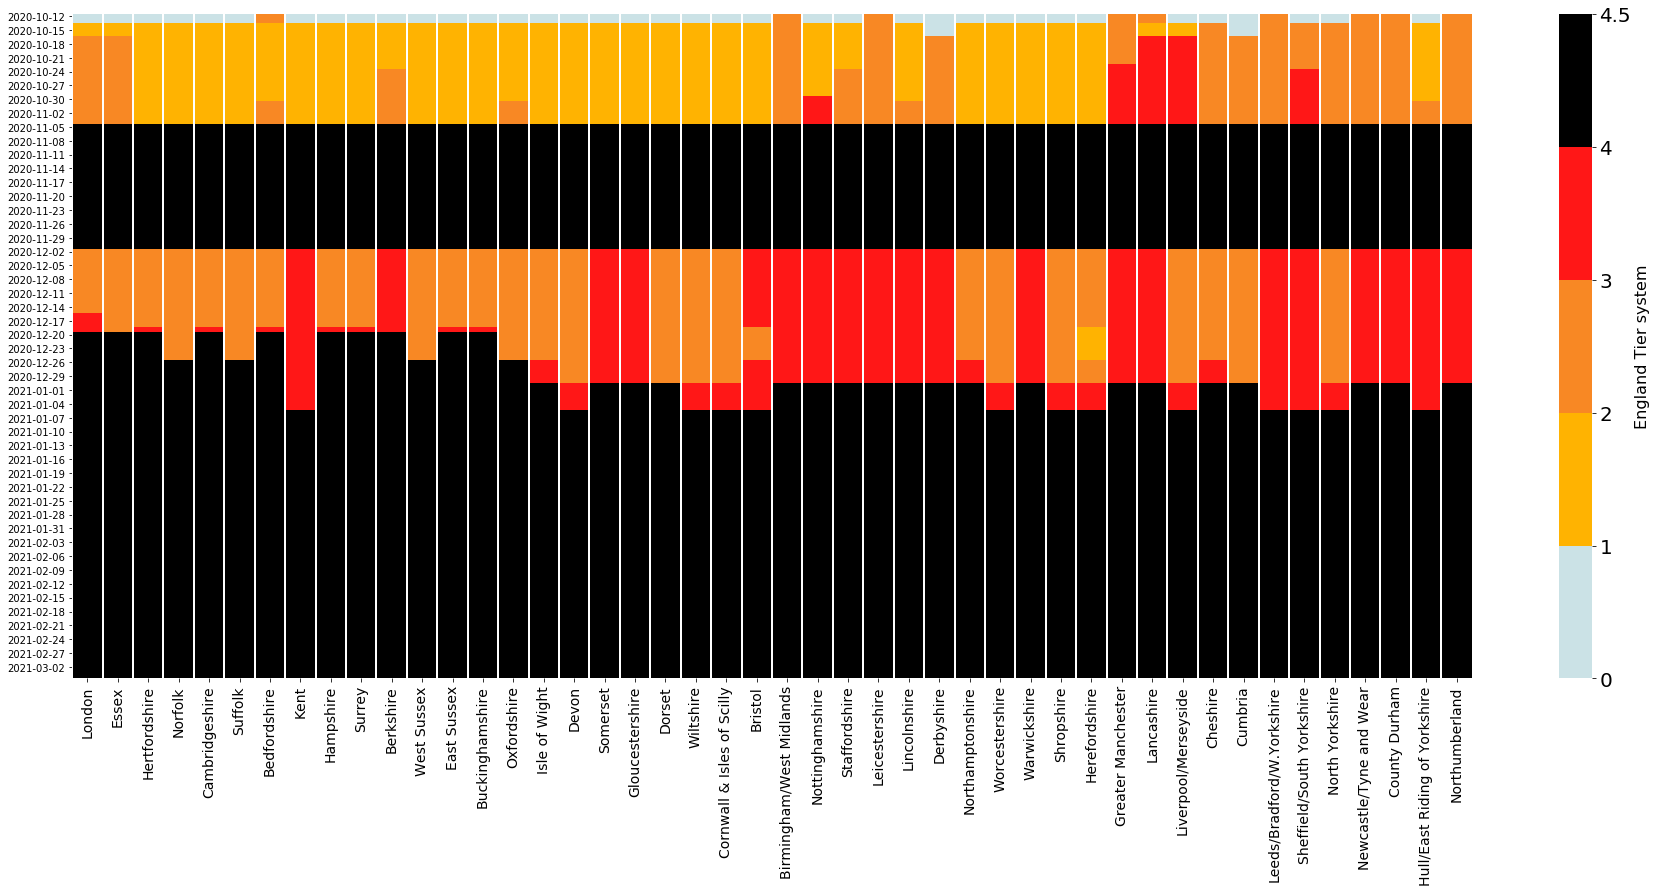

In [57]:
region_list2 = geodata[(~geodata.geotype.isin(['NHS Region','Nation']))&(geodata.country=='England')].groupby(['nhsRegion','county']).pop.sum().reset_index()
region_list2['region_sort'] = region_list2.nhsRegion.apply(lambda row: region_keys[row])
region_list2 = region_list2.sort_values(['region_sort','pop'], ascending=[True,False]).reset_index()
region_list2 = ['London'] + list(region_list2.county)[5:]

data = england.copy()
data = data[data.date>=pd.to_datetime('20201012', format='%Y%m%d')]
data['date'] = data['date'].dt.date
dfgrid2 = pd.pivot_table(data, values='tier', index='date', columns='area', aggfunc=np.max)
dfgrid2 = dfgrid2[region_list2].fillna(0)

fig, ax = plt.subplots(figsize=(25.5,12.5))

cmap = colors.ListedColormap(['#CBE2E6','#FFB301','#F88824','#FF1717','black'])
bounds=[0,1,2,3,4,4.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax = sns.heatmap(dfgrid2, cmap=cmap, norm=norm)
ax.vlines(range(len(region_list2)), *ax.get_ylim(), color='white', lw=2)  

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(bounds)
colorbar.set_ticklabels(bounds)
colorbar.set_label('England Tier system', size=16)
colorbar.ax.tick_params(labelsize=20)

ax.tick_params(axis='x', labelsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_ylabel('')    
ax.set_xlabel('')

plt.tight_layout()
plt.savefig(f"covid-uk8_tiers", pad_inches=0, bbox_inches="tight")
plt.show()

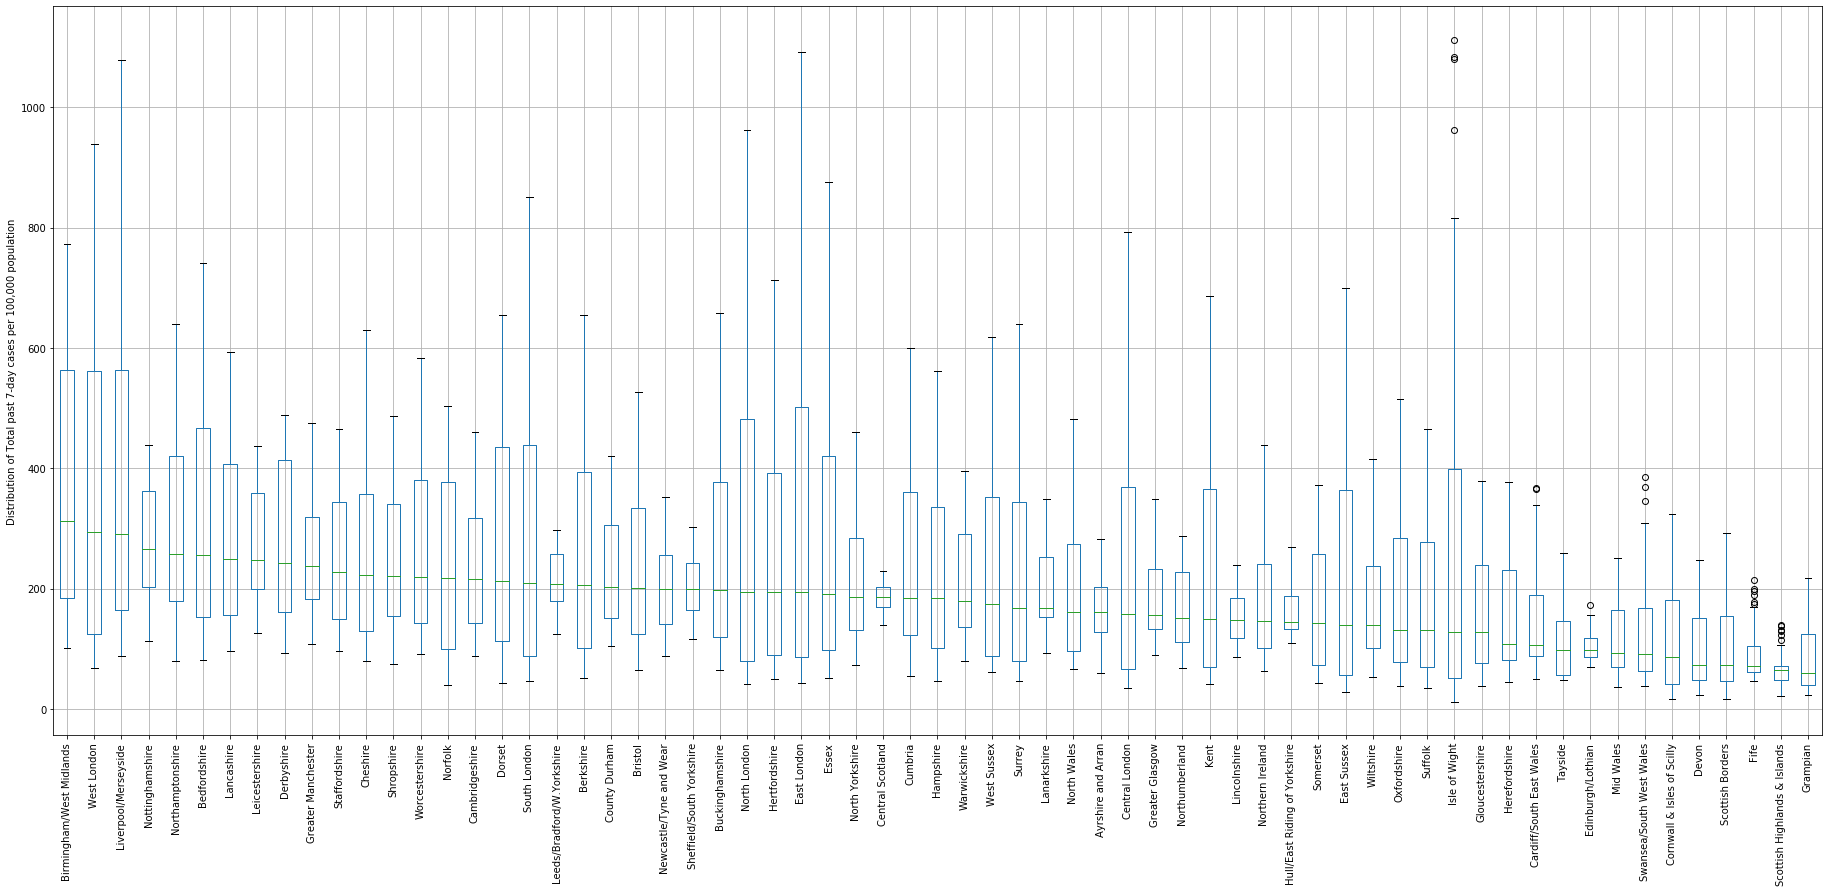

In [104]:
region_list3 = geodata[~geodata.geotype.isin(['Country', 'Nation', 'NHS Region'])].county.unique()
region_list3 = list(ukdata[ukdata.area.isin(region_list3)].groupby('area').cases_100k.median().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(25.5,12.5))
boxdata2 = ukdata.pivot(columns='area',values='cases_100k')[region_list3]
boxdata2.boxplot()
plt.xticks(rotation=90)
# ax.set_ylim(-0,1200)
ax.set_ylabel('Distribution of Total past 7-day cases per 100,000 population')
plt.tight_layout()
plt.savefig(f"covid-uk9-incidence_spread", pad_inches=0, bbox_inches="tight")
plt.show()

In [58]:
# my_ori = pd.read_csv('covid-19-my-states-cases_processed.csv', index_col=0)
# my_fix = pd.read_csv('covid-19-my-states-cases_processed_fix.csv', index_col=0)

# last_date = my_ori.date.max()
# kv_last = my_ori[(my_ori.state=='Selangor + KL + Putrajaya') & (my_ori.date==last_date)].cases_100k.values[0]
# my_last = my_ori[(my_ori.state=='Malaysia') & (my_ori.date==last_date)].cases_100k.values[0]

# kv_max  = my_ori[(my_ori.state=='Selangor + KL + Putrajaya')].reset_index().iloc[2:].cases_100k.max()
# my_max  = my_ori[(my_ori.state=='Malaysia')].reset_index().iloc[2:].cases_100k.max()
# kv_max_date = my_ori[(my_ori.state=='Selangor + KL + Putrajaya')&(my_ori.cases_100k==kv_max)].date.values[-1]
# my_max_date = my_ori[(my_ori.state=='Malaysia')&(my_ori.cases_100k==my_max)].date.values[-1]

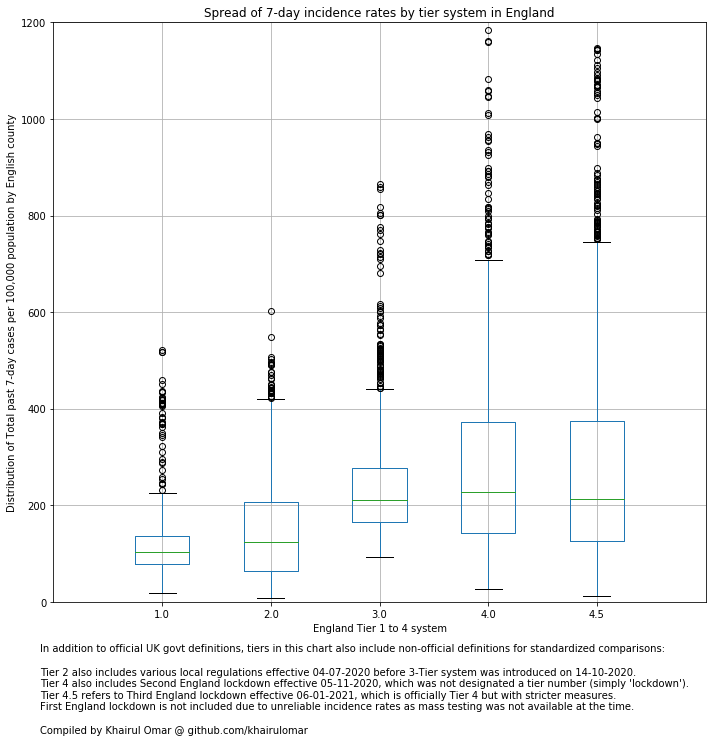

In [82]:
fig, ax = plt.subplots(figsize=(10,9))
boxdata = england[england.tier>0][['tier','cases_100k']]
boxdata = boxdata.pivot(columns='tier', values='cases_100k')
boxdata.boxplot()

ax.set_ylim(-0,1200)
ax.set_xlim(0, 6)
ax.set_xlabel('England Tier 1 to 4 system')
ax.set_ylabel('Distribution of Total past 7-day cases per 100,000 population by English county')

# ax.hlines(kv_max,  0, 6, lw=1.5, label=f'Selangor + KL + Putrajaya : highest on {calendar.month_name[int(kv_max_date[5:7])][:3]} {int(kv_max_date[-2:])}', ls='dashed', color='red')
# ax.hlines(kv_last, 0, 6, lw=1, label=f'Selangor + KL + Putrajaya : latest on {calendar.month_name[int(last_date[5:7])][:3]} {int(last_date[-2:])}', ls='dashed', color='red')

# ax.hlines(my_max,  0, 6, lw=1.5, label=f'Malaysia (total) : highest on {calendar.month_name[int(my_max_date[5:7])][:3]} {int(my_max_date[-2:])}', ls='dashed', color='blue')
# ax.hlines(my_last, 0, 6, lw=1, label=f'Malaysia (total) : latest on {calendar.month_name[int(last_date[5:7])][:3]} {int(last_date[-2:])}', ls='dashed', color='blue')

txt = "In addition to official UK govt definitions, tiers in this chart also include non-official definitions for standardized comparisons:\
      \n\nTier 2 also includes various local regulations effective 04-07-2020 before 3-Tier system was introduced on 14-10-2020.\
      \nTier 4 also includes Second England lockdown effective 05-11-2020, which was not designated a tier number (simply 'lockdown').\
      \nTier 4.5 refers to Third England lockdown effective 06-01-2021, which is officially Tier 4 but with stricter measures.\
      \nFirst England lockdown is not included due to unreliable incidence rates as mass testing was not available at the time.\
      \n\nCompiled by Khairul Omar @ github.com/khairulomar"
plt.figtext(0.06, 0, txt, fontsize=10, ha='left', va='top')


# plt.title("Benchmarking Malaysia's reponse with England's Tier system\nby comparing total 7-day incidence rates", fontsize=16)
plt.title("Spread of 7-day incidence rates by tier system in England")
plt.grid(b=True, axis='y', which='minor')
# plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f"covid-uk10-tier_spread", pad_inches=0, bbox_inches="tight")
plt.show()

In [60]:
shift = -14
data = ukdata_all[ukdata_all.area=='United Kingdom'].set_index('date')

from sklearn.linear_model import LinearRegression

wave2_x = np.array(data[data.wave==2].shift(shift).hospital_avg7)[:shift]
wave2_x_reshape = wave2_x.reshape(-1, 1)

wave2_y = np.array(data[data.wave==2].cases_avg7)[:shift]

reg = LinearRegression().fit(wave2_x_reshape, wave2_y)
reg.score(wave2_x_reshape, wave2_y)

0.9146624653367555

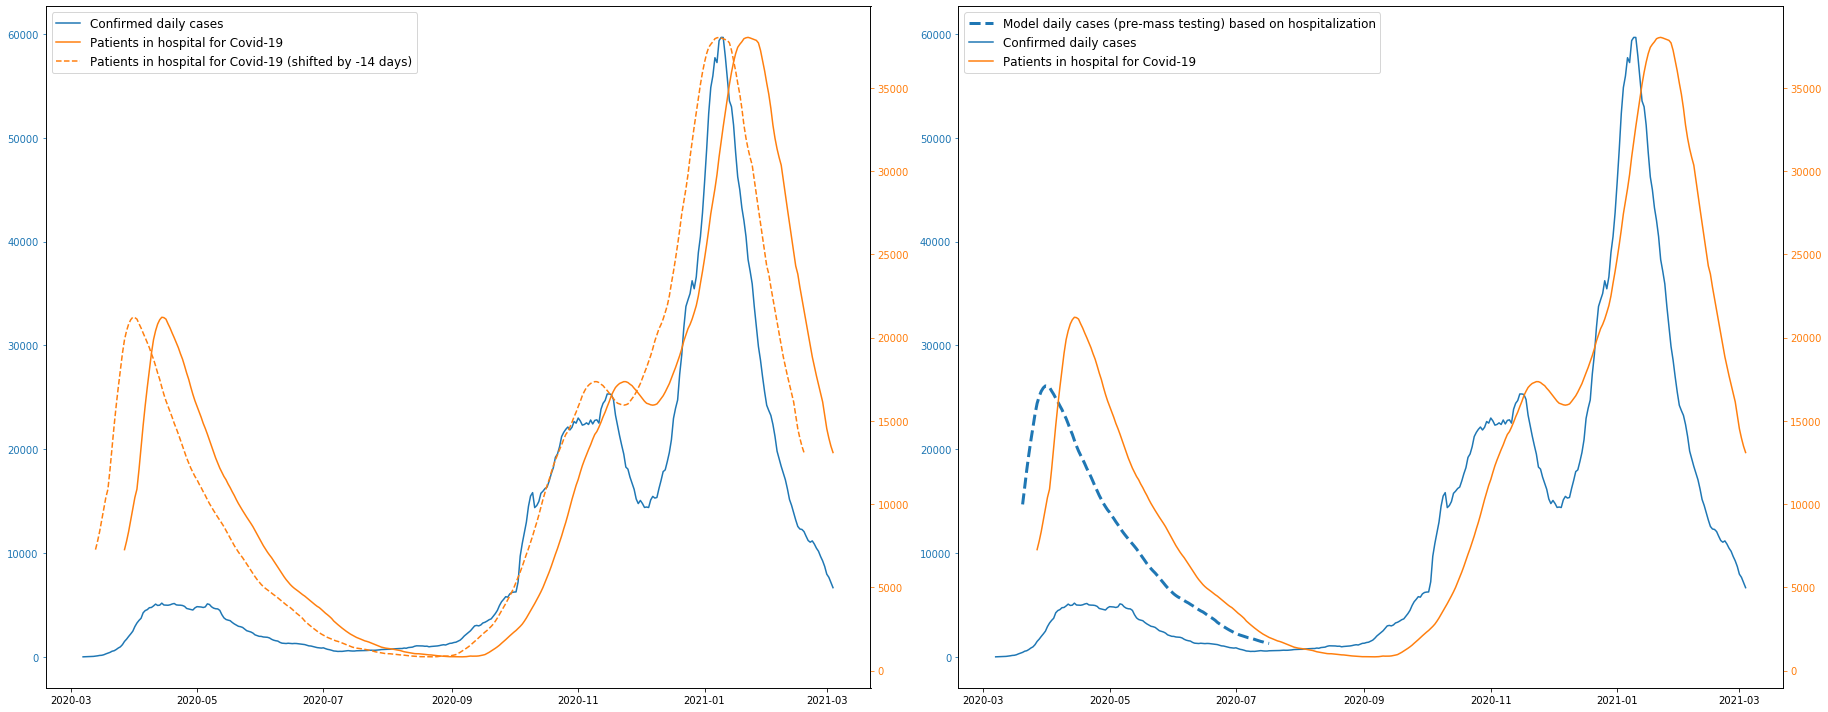

In [61]:
wave1_x = np.array(data[data.wave==1].shift(shift).hospital_avg7)[13:shift]
wave1_x_reshape = wave1_x.reshape(-1, 1)
wave1_model = reg.predict(wave1_x_reshape)

index = data[data.wave==1].shift(shift).hospital_avg7[13:shift].index
wave1_model = pd.DataFrame(wave1_model, columns=['cases_avg7_model'], index=index)

plt.close()
fig, ax = plt.subplots(figsize=(25.5,10), nrows=1, ncols=2)

n = 0
ln1 = ax[n].plot(data.cases_avg7, label='Confirmed daily cases')
ax2 = ax[n].twinx()
ln2 = ax2.plot(data.hospital_avg7, c='C1', label='Patients in hospital for Covid-19')
ln3 = ax2.plot(data.hospital_avg7.shift(shift), linestyle='dashed', c='C1', label=f'Patients in hospital for Covid-19 (shifted by {shift} days)')
lns = ln1 + ln2 + ln3
labels = [l.get_label() for l in lns]
ax[n].legend(lns, labels, loc=0, fontsize=12)
# ax[n].set_ylabel('Confirmed daily cases')
# ax2.set_ylabel('Patients in hospital for Covid-19')
ax[n].tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')

n = 1
ln1a= ax[n].plot(wave1_model, label='Model daily cases (pre-mass testing) based on hospitalization', c='C0', linestyle='dashed', lw=3)
ln1 = ax[n].plot(data.cases_avg7, label='Confirmed daily cases', c='C0')
ax2 = ax[n].twinx()
ln2 = ax2.plot(data.hospital_avg7, c='C1', label='Patients in hospital for Covid-19')
# ax[n].vlines(wave1_model_max_date[0], wave1_max, wave1_model_max)
lns = ln1a + ln1 + ln2
labels = [l.get_label() for l in lns]
ax[n].legend(lns, labels, loc=0, fontsize=12)
ax[n].tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')

plt.tight_layout()
plt.savefig("covid-uk11_model_first_wave", pad_inches=0)
plt.show()

In [62]:
# wave1_model_max = wave1_model.cases_avg7_model.max()
# wave1_model_max_date = wave1_model[wave1_model.cases_avg7_model==wave1_model_max].index
# wave1_max = data.loc[wave1_model_max_date].index

In [63]:
# # Data prediction using Richard's curve (Generalized logistic function)

# def plot_predict(start_date, end_date, future_days=30, rolling=7, col='deaths'):

# # col = 'deaths'
# # start_date = '2020-12-26'
# # end_date   = '2021-02-02'
# # future_days = 30
# # rolling = 7

#     from scipy.optimize import curve_fit

#     model_data = ukdata_all.copy()
#     model_data[f'{col}_avg'] = round(model_data[col].transform(lambda row: row.rolling(window=rolling, min_periods=1).mean()),1)
#     model_data[f'{col}_total_avg'] = model_data[f'{col}_avg'].cumsum()
#     model_data[f'{col}_total'] = model_data[col].cumsum()

#     start_date  = pd.to_datetime(start_date, format='%Y-%m-%d')
#     end_date    = pd.to_datetime(end_date, format='%Y-%m-%d')
#     end_model   = end_date + pd.DateOffset(future_days)
#     days        = (end_date - start_date).days + future_days + 1
#     model_data = model_data[(model_data.date>=start_date)&(model_data.date<=end_date)]

#     def richards(x, A, K, C, Q, B, v):
#         y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
#         return y

#     xdata  = np.array(range(len(model_data)))
#     ydata  = np.array(model_data[f'{col}_total_avg'])
#     y0data = np.array(model_data[f'{col}_total'])

#     popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
#     A, K, C, Q, B, v = popt

#     # Calculate prediction over required num of days
#     xdata2     = np.array(range(days))
#     pred_calc  = richards(xdata2, A, K, C, Q, B, v)

#     xticks = []
#     day = start_date - pd.DateOffset(1)
#     while day < end_model:
#         day = day + pd.DateOffset(1)
#         xticks.append(day)
#     xticks = np.array(xticks)

#     model = pd.DataFrame({f'{col}_total':pd.Series(y0data),
#                           f'{col}_total_avg':pd.Series(ydata),
#                           f'{col}_total_pred':pd.Series(pred_calc),
#                              col:pd.Series(np.array(model_data[col])),
#                           f'{col}_avg':pd.Series(np.array(model_data[f'{col}_avg']))})
#     model.index = xticks
#     model[f'{col}_pred'] = model[f'{col}_total_pred'].diff()


#     fig, ax = plt.subplots(figsize=(14,5), nrows=1, ncols=2)

#     for i in [0,1]:
#         if i==0:
#             # ax[i].plot(model.index, model[f'{col}_total_avg'], label=f'Actual cumulative {col} (smoothed)', c='C0')
#             ax[i].plot(model.index, model[f'{col}_total'], label=f'Actual cumulative {col}', c='C0')

#         if i==1:
#             ax[i].plot(model.index, model[f"{col}{'' if i==1 else '_total'}_avg"], label=f'Past {rolling}-day average', c='C0')
#             ax[i].scatter(model.index, model[col], alpha=0.4, label=f'Actual new {col}', c='C0', s=20)

#         ax[i].plot(model.index, model[f"{col}{'' if i==1 else '_total'}_pred"], label=f'Model {col} trajectory', c='C1')

#         ax[i].set_xlim(start_date + pd.DateOffset(-3), end_model + pd.DateOffset(2))
#         ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
# #         ax[i].text(0.02, 0.97, f"Fitting Richard's curve: \
# #                             \n\nSmoothing average = {rolling} day{'s' if rolling > 1 else ''}\
# #                             \nFit start date = {start_date.day} {calendar.month_name[start_date.month][:3]} {start_date.year} \
# #                             \nFit end date = {end_date.day} {calendar.month_name[end_date.month][:3]} {end_date.year} \
# #                             \nPeriod of forecast = {future_days} days \
# #                             \nA={int(A)}     \nK={int(K)}     \nC={round(C,4)} \
# #                             \nQ={round(Q,4)} \nB={round(B,4)} \nv={round(v,4)}", \
# #                             va='top', ha='left', size=10, transform=ax[i].transAxes)
#         ax[i].legend(loc='lower right', frameon=False,)
#         ax[i].set_title(f"{f'New daily {col}' if i==1 else f'Cumulative {col}'}", fontsize=14)
#         fig.autofmt_xdate(rotation=90)
#     plt.tight_layout()
#     plt.show()

In [64]:
# for col in ['cases','deaths']:
#     plot_predict(col=col,
#                  start_date='2020-11-01',
#                  end_date='2021-02-06',
#                  future_days=30,
#                  rolling=7)